In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
import tqdm
import json
import torch
import warnings
import numpy as np
import torch.nn as nn
from datetime import datetime
import torch.nn.functional as F
import matplotlib.pyplot as plt
from chnet.torchsummary import summary
from torchvision import transforms, utils
from toolz.curried import pipe, curry, compose
from torch.utils.data import Dataset, DataLoader

In [3]:
import utilities as utils
import chnet.cahn_hill as ch
import chnet.ch_tools as tools

In [4]:
from chnet.unet import UNet
from chnet.ch_net import CHnet
from chnet.ch_loader import CahnHillDataset

In [5]:
warnings.filterwarnings('ignore')

In [6]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

def draw_im(im, title=None):
    im = np.squeeze(im)
    plt.imshow(im)
    plt.colorbar()
    if title is not None:
        plt.title(title)
    plt.show()
    
@curry
def return_slice(x_data, cutoff):
    if cutoff is not None:
        return pipe(x_data,
                    lambda x_data: np.asarray(x_data.shape).astype(int) // 2,
                    lambda new_shape: [slice(new_shape[idim]-cutoff,
                                             new_shape[idim]+cutoff+1)
                                       for idim in range(x_data.ndim)],
                    lambda slices: x_data[slices])
    else:
        return x_data
    
cropper = return_slice(cutoff=5)

In [15]:
def init_unif(nsamples, dim_x, dim_y, seed=354875):
    np.random.seed(seed)
    return np.random.uniform(-0.98, 0.98, size=(nsamples, dim_x, dim_y))


def init_norm(nsamples, dim_x, dim_y, seed=354875):
    np.random.seed(seed)
    means  = np.random.uniform(-0.7, 0.7, size=nsamples)
    np.random.seed(seed)
    scales  = np.random.uniform(0.1, 0.5, size=nsamples)
    
    x_data = [np.random.normal(loc=m, scale=s, size = (1, dim_x, dim_y)) for m,s in zip(means, scales)]
    x_data = np.concatenate(x_data, axis=0)
    
    np.clip(x_data, -0.95, 0.95, out=x_data)
    
    return x_data

## Loss Functions

In [51]:
@curry
def mse_loss(y1, y2, scale=1.):
    """standard MSE definition"""
    return ((y1* scale - y2* scale) ** 2).sum() / y1.data.nelement() 

@curry
def rmse_loss(y1, y2, scale=1.):
    """standard RMSE definition"""
    return ((((y1 - y2) ** 2).sum() / y1.data.nelement()).sqrt()) * scale


def mse_loss_npy(y1, y2):
    """standard MSE definition"""
    return np.sum(((y1 - y2) ** 2)) / y1.size

## Transformers

In [17]:
@curry
def add_neighbors(x):
    dimx = x.shape[0]
    y = np.pad(x, pad_width=[[2,2],[2,2]], mode="wrap")
    out = [x[None]]
    for ix in [0, 1, 2, 3, 4]:
        for iy in [0, 1, 2, 3, 4]:
            out.append((y[ix:ix+dimx, iy:iy+dimx] * x)[None])
    return np.concatenate(out, axis=0)

## Data Generators

In [18]:
@curry
def data_generator(nsamples=128, 
                   dim_x=64, 
                   init_steps=100, 
                   delta_sim_steps = 500,
                   dx = 0.25, 
                   dt = 0.01,
                   gamma=1.0, 
                   seed = None,
                   device = torch.device("cuda:0")):
    
    init_data1 = init_unif(nsamples//2, dim_x, dim_x, seed=seed)
    init_data2 = init_norm(nsamples//2, dim_x, dim_x, seed=seed)
    init_data = np.concatenate([init_data1, init_data2], axis=0)
    
    x_data = ch.ch_run_torch(init_data, dt=dt, gamma=gamma, 
                             dx=dx, sim_step=init_steps, device=device)
    y_data = ch.ch_run_torch(x_data, dt=dt, gamma=gamma, 
                             dx=dx, sim_step=delta_sim_steps, device=device)
    return x_data, y_data

In [22]:
x_data, y_data = data_generator(nsamples=16, dim_x=64, 
                                init_steps=10, 
                                delta_sim_steps = 50,
                                dx = 0.25, 
                                dt = 0.01,
                                gamma=1.0, 
                                seed = None,
                                device = torch.device("cuda:0"))

# Set Device

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CNN Model

In [24]:
from chnet.unet import UNet
model = UNet(in_channels=1, 
             out_channels=1, 
             init_features=32).to(device)
summary(model, input_size=(1, 64, 64))

# model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', 
#                        in_channels=1, 
#                        out_channels=1, 
#                        init_features=32, 
#                        pretrained=False).double().to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             288
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           9,216
       BatchNorm2d-5           [-1, 32, 64, 64]              64
              ReLU-6           [-1, 32, 64, 64]               0
         MaxPool2d-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          18,432
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
        MaxPool2d-14           [-1, 64,

(tensor(7762465), tensor(7762465))

In [25]:
# transformer_x = lambda x: x[None]
# transformer_y = lambda x: x[None]
from pymks.bases import LegendreBasis

n_states = 3
domain = (-1.01, 1.01)
basis = LegendreBasis(n_states, domain)
transformer_x = lambda x: np.moveaxis(basis.discretize(x), 2, 0)
transformer_y = lambda x: x[None]



dataset = CahnHillDataset(x_data, y_data, transform_x=transformer_x, transform_y=transformer_y)

item = dataset[0]
x = item["x"][None].to(device)
y = item["y"][None].to(device)

print(x.shape, y.shape)

torch.Size([1, 3, 64, 64]) torch.Size([1, 1, 64, 64])


In [26]:
model = UNet(in_channels=n_states, 
             out_channels=1, 
             init_features=32).double().to(device)

item = dataset[0]
x = item["x"][None].to(device)
y = item["y"][None].to(device)
y_pred = model(x)

assert y.shape == y_pred.shape
print(mse_loss(y, y_pred).data)

tensor(0.0054, device='cuda:0', dtype=torch.float64)


# Model Training

### Training and Validation data generation

In [27]:
## Process Parameters
dim_x=64
init_steps=1
delta_sim_steps = 2500
dx = 0.25 
dt = 0.01
gamma=1.0

seed_trn = 110364
seed_val = 986423
seed_prd = 284296


trn_size = 30
n_samples_trn = 1024*trn_size
n_samples_val = 128
n_samples_prd = 32

init_features=32

args = {}
args["dim_x"] = dim_x
args["init_steps"] = init_steps
args["delta_sim_steps"] = delta_sim_steps
args["dx"] = dx
args["dt"] = dt
args["gamma"] = gamma
args["seed_trn"] = seed_trn
args["seed_val"] = seed_val
args["seed_val"] = seed_prd

args["n_samples_trn"] = n_samples_trn
args["n_samples_val"] = n_samples_val
args["n_samples_prd"] = n_samples_prd

args["init_features"] = init_features

In [28]:
%%time
x_trn, y_trn = data_generator(nsamples=n_samples_trn, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =seed_trn,
                                device = device)



x_val, y_val = data_generator(nsamples=n_samples_val, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =seed_val,
                                device = device)

x_prd, y_prd = data_generator(nsamples=n_samples_prd, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =seed_prd,
                                device = device)

CPU times: user 1min 9s, sys: 1min 6s, total: 2min 16s
Wall time: 2min 15s


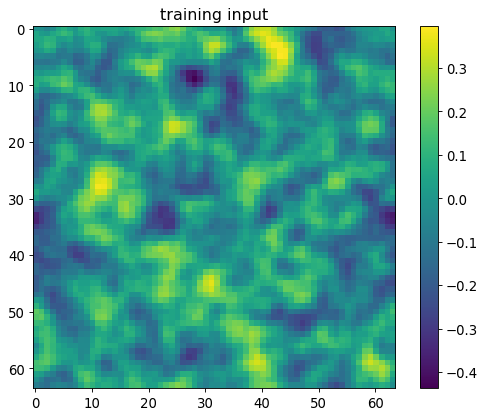

In [29]:
draw_im(x_trn[0], "training input")

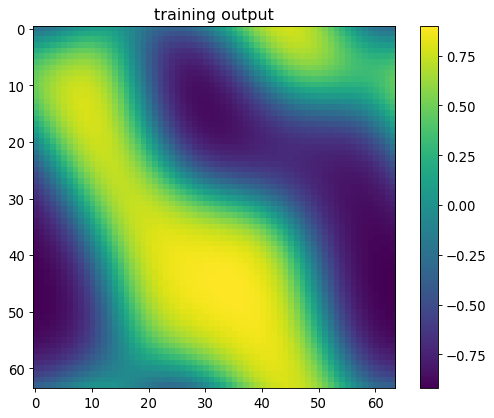

In [30]:
draw_im(y_trn[0], "training output")

In [60]:
from pymks.bases import LegendreBasis

n_states = 7
domain = (-1.01, 1.01)
basis = LegendreBasis(n_states, domain)
transformer_x = lambda x: np.moveaxis(basis.discretize(x), 2, 0)
transformer_y = lambda x: x[None]

trn_dataset = CahnHillDataset(x_trn, y_trn, transform_x=transformer_x, transform_y=transformer_y)
val_dataset = CahnHillDataset(x_val, y_val, transform_x=transformer_x, transform_y=transformer_y)

x_prd, y_prd = data_generator(nsamples=n_samples_prd, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =seed_prd,
                                device = device)
prd_dataset = CahnHillDataset(x_prd, y_prd, transform_x=transformer_x, transform_y=transformer_y)

batch_size = 32

trn_loader = DataLoader(trn_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
prd_loader = DataLoader(prd_dataset, batch_size=8, shuffle=True, num_workers=1)


total_step = len(trn_loader)
print("No. of training steps: %d" % total_step)
total_val_step = len(val_loader)
print("No. of validation steps: %d" % total_val_step)
total_val_step = len(prd_loader)
print("No. of prediction steps: %d" % total_val_step)

No. of training steps: 960
No. of validation steps: 4
No. of prediction steps: 4


In [34]:
dt_string = datetime.now().strftime("%d-%m-%Y-%H-%M")

In [35]:
run_id = dt_string + "_run_leg_{}_data_{}_longrun".format(n_states, trn_size)
print(run_id)

folder = "out/unet/ch_unet_id_{}/".format(run_id)
print(folder)


tag = folder+"unet_"
print(tag)

14-04-2020-01-19_run_leg_7_data_30_longrun
out/unet/ch_unet_id_14-04-2020-01-19_run_leg_7_data_30_longrun/
out/unet/ch_unet_id_14-04-2020-01-19_run_leg_7_data_30_longrun/unet_


In [37]:
if not os.path.exists(folder):
    os.makedirs(folder)
    
with open(folder+'params.json', 'w') as fp:
    json.dump(args, fp)

In [55]:
from chnet.unet import UNet
model = UNet(in_channels=n_states, 
             out_channels=1, 
             init_features=init_features).double().to(device)

In [56]:
num_epochs = 50
criterion = mse_loss(scale=100)
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
trn_losses = []
val_losses = []

In [61]:
# Loss and optimizer
for epoch in range(2, num_epochs):    
    torch.save(model.state_dict(), tag+"epoch_{}.pt".format(epoch))              
    for i, item_trn in enumerate(tqdm.tqdm_notebook(trn_loader)):
        
        
        model.train()
        
        x = item_trn['x'].to(device)
        y_t = item_trn['y'].to(device)

        # Forward pass
        y_p = model(x)
        loss = criterion(y_t, y_p)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        trn_losses.append(np.sqrt(loss.item()))
        
        if (i) % 128 == 0:
            for item_val in val_loader:
                model.eval()
                x1 = item_trn['x'].to(device)
                y1 = item_trn['y'].to(device)
                # Forward pass
                y2 = model(x1)
                val_losses.append(np.sqrt(criterion(y2, y1).item()))
                    
            print ('Epoch [{}/{}], Step [{}/{}], Training Loss: {:.11f}, Validation Loss: {:.11f}'.format(epoch+1, 
                                                                                                          num_epochs, 
                                                                                                          i+1, 
                                                                                                          total_step, 
                                                                                                          np.mean(trn_losses[-16:]), 
                                                                                                          np.mean(val_losses[-total_val_step:])))
            
torch.save(model.state_dict(), tag+"epoch_{}.pt".format(num_epochs)) 
torch.save(trn_losses, tag+"trn_loss.pt")
torch.save(val_losses, tag+"val_loss.pt")

Epoch [3/50], Step [1/960], Training Loss: 15.08254671296, Validation Loss: 17.88251651766
Epoch [3/50], Step [129/960], Training Loss: 13.04978871093, Validation Loss: 11.62702976200
Epoch [3/50], Step [257/960], Training Loss: 13.22814264351, Validation Loss: 13.36615479558
Epoch [3/50], Step [385/960], Training Loss: 12.69170301801, Validation Loss: 13.20936913053
Epoch [3/50], Step [513/960], Training Loss: 12.33092485053, Validation Loss: 12.13634109714
Epoch [3/50], Step [641/960], Training Loss: 12.86590205634, Validation Loss: 13.21796428074
Epoch [3/50], Step [769/960], Training Loss: 12.24377803573, Validation Loss: 11.56620772238
Epoch [3/50], Step [897/960], Training Loss: 11.94382058116, Validation Loss: 12.10579806538



Epoch [4/50], Step [1/960], Training Loss: 12.06843818330, Validation Loss: 11.14274643371
Epoch [4/50], Step [129/960], Training Loss: 11.49922265704, Validation Loss: 11.21618795247
Epoch [4/50], Step [257/960], Training Loss: 11.52718846628, Validation Loss: 10.66674703185
Epoch [4/50], Step [385/960], Training Loss: 11.45502590896, Validation Loss: 11.74004949343
Epoch [4/50], Step [513/960], Training Loss: 11.09384110426, Validation Loss: 11.10171038907
Epoch [4/50], Step [641/960], Training Loss: 11.06252776072, Validation Loss: 10.59882796071
Epoch [4/50], Step [769/960], Training Loss: 10.76652952599, Validation Loss: 9.83823514192
Epoch [4/50], Step [897/960], Training Loss: 10.84968536981, Validation Loss: 8.38773220996



Epoch [5/50], Step [1/960], Training Loss: 10.68720850002, Validation Loss: 11.25684641323
Epoch [5/50], Step [129/960], Training Loss: 10.51475345580, Validation Loss: 10.09119832862
Epoch [5/50], Step [257/960], Training Loss: 10.16328959421, Validation Loss: 8.95152558741
Epoch [5/50], Step [385/960], Training Loss: 10.79239827646, Validation Loss: 10.27425130617
Epoch [5/50], Step [513/960], Training Loss: 10.20059956227, Validation Loss: 10.59998509333
Epoch [5/50], Step [641/960], Training Loss: 10.17023108767, Validation Loss: 8.90206306293
Epoch [5/50], Step [769/960], Training Loss: 10.48526632077, Validation Loss: 9.76401831914
Epoch [5/50], Step [897/960], Training Loss: 9.82584700925, Validation Loss: 10.21274739367



Epoch [6/50], Step [1/960], Training Loss: 9.73838766918, Validation Loss: 9.71841742806
Epoch [6/50], Step [129/960], Training Loss: 9.44039825254, Validation Loss: 8.48486812136
Epoch [6/50], Step [257/960], Training Loss: 9.71830858828, Validation Loss: 7.89538704628
Epoch [6/50], Step [385/960], Training Loss: 9.59179351184, Validation Loss: 9.03613952696
Epoch [6/50], Step [513/960], Training Loss: 9.44127638077, Validation Loss: 9.09179383478
Epoch [6/50], Step [641/960], Training Loss: 9.67933007582, Validation Loss: 9.85740249095
Epoch [6/50], Step [769/960], Training Loss: 9.19485257182, Validation Loss: 8.66207618833
Epoch [6/50], Step [897/960], Training Loss: 9.44976769312, Validation Loss: 8.55056134077



Epoch [7/50], Step [1/960], Training Loss: 8.93603592628, Validation Loss: 8.33373606325
Epoch [7/50], Step [129/960], Training Loss: 8.84306483057, Validation Loss: 8.51627485055
Epoch [7/50], Step [257/960], Training Loss: 8.73172720268, Validation Loss: 9.23257900796
Epoch [7/50], Step [385/960], Training Loss: 8.57679422177, Validation Loss: 8.10402876163
Epoch [7/50], Step [513/960], Training Loss: 8.72212739385, Validation Loss: 7.62973739525
Epoch [7/50], Step [641/960], Training Loss: 8.67724666708, Validation Loss: 7.89985574292
Epoch [7/50], Step [769/960], Training Loss: 8.56133799710, Validation Loss: 8.01024706728
Epoch [7/50], Step [897/960], Training Loss: 8.46246244161, Validation Loss: 7.84690213267



Epoch [8/50], Step [1/960], Training Loss: 8.40543385396, Validation Loss: 7.13221929473
Epoch [8/50], Step [129/960], Training Loss: 8.09560207033, Validation Loss: 7.23324556052
Epoch [8/50], Step [257/960], Training Loss: 8.40142127004, Validation Loss: 7.82294509251
Epoch [8/50], Step [385/960], Training Loss: 7.98402844594, Validation Loss: 7.98092201598
Epoch [8/50], Step [513/960], Training Loss: 8.15261880418, Validation Loss: 8.10552097101
Epoch [8/50], Step [641/960], Training Loss: 8.53843800161, Validation Loss: 7.69627890346
Epoch [8/50], Step [769/960], Training Loss: 8.03692495525, Validation Loss: 7.69603231956
Epoch [8/50], Step [897/960], Training Loss: 8.03312182048, Validation Loss: 7.13945603620



Epoch [9/50], Step [1/960], Training Loss: 8.63984836032, Validation Loss: 8.17494268634
Epoch [9/50], Step [129/960], Training Loss: 7.68711741770, Validation Loss: 7.05277733034
Epoch [9/50], Step [257/960], Training Loss: 7.50599198114, Validation Loss: 6.48817772713
Epoch [9/50], Step [385/960], Training Loss: 7.71615875186, Validation Loss: 6.96560998811
Epoch [9/50], Step [513/960], Training Loss: 7.56949985757, Validation Loss: 6.94829311514
Epoch [9/50], Step [641/960], Training Loss: 7.41250766991, Validation Loss: 6.36389778900
Epoch [9/50], Step [769/960], Training Loss: 7.58152222755, Validation Loss: 7.38638349209
Epoch [9/50], Step [897/960], Training Loss: 7.41134514889, Validation Loss: 6.39779760581



Epoch [10/50], Step [1/960], Training Loss: 7.74067502884, Validation Loss: 6.55096954634
Epoch [10/50], Step [129/960], Training Loss: 7.71828814108, Validation Loss: 6.49239896777
Epoch [10/50], Step [257/960], Training Loss: 7.60797962293, Validation Loss: 6.90589143491
Epoch [10/50], Step [385/960], Training Loss: 7.47924734156, Validation Loss: 6.99272457438
Epoch [10/50], Step [513/960], Training Loss: 7.44356682587, Validation Loss: 7.13780371636
Epoch [10/50], Step [641/960], Training Loss: 7.20861071387, Validation Loss: 6.91257668057
Epoch [10/50], Step [769/960], Training Loss: 7.40757405179, Validation Loss: 7.10208046149
Epoch [10/50], Step [897/960], Training Loss: 7.21913048320, Validation Loss: 6.54014275853



Epoch [11/50], Step [1/960], Training Loss: 7.19451614814, Validation Loss: 6.38749126322
Epoch [11/50], Step [129/960], Training Loss: 6.94089779138, Validation Loss: 6.05627613946
Epoch [11/50], Step [257/960], Training Loss: 6.83419052558, Validation Loss: 5.85835917111
Epoch [11/50], Step [385/960], Training Loss: 6.89826378911, Validation Loss: 6.34930749037
Epoch [11/50], Step [513/960], Training Loss: 6.83602803894, Validation Loss: 6.17447668095
Epoch [11/50], Step [641/960], Training Loss: 6.93631292928, Validation Loss: 5.94478516564
Epoch [11/50], Step [769/960], Training Loss: 6.73818288252, Validation Loss: 6.29289403351
Epoch [11/50], Step [897/960], Training Loss: 6.67705951205, Validation Loss: 6.26850312028



Epoch [12/50], Step [1/960], Training Loss: 7.19255753019, Validation Loss: 6.58250966464
Epoch [12/50], Step [129/960], Training Loss: 6.57182320590, Validation Loss: 6.31971406629
Epoch [12/50], Step [257/960], Training Loss: 6.57402247706, Validation Loss: 5.84312497465
Epoch [12/50], Step [385/960], Training Loss: 6.64601501625, Validation Loss: 5.83907755093
Epoch [12/50], Step [513/960], Training Loss: 6.42779058128, Validation Loss: 6.03978986356
Epoch [12/50], Step [641/960], Training Loss: 6.50706505660, Validation Loss: 6.04461235486
Epoch [12/50], Step [769/960], Training Loss: 6.55367768882, Validation Loss: 6.03300151713
Epoch [12/50], Step [897/960], Training Loss: 6.68174939645, Validation Loss: 6.52679468151



Epoch [13/50], Step [1/960], Training Loss: 6.34702495002, Validation Loss: 5.30759203241
Epoch [13/50], Step [129/960], Training Loss: 6.26465998033, Validation Loss: 5.68342651575
Epoch [13/50], Step [257/960], Training Loss: 6.08254569773, Validation Loss: 5.55476876121
Epoch [13/50], Step [385/960], Training Loss: 6.32087703268, Validation Loss: 5.79150916424
Epoch [13/50], Step [513/960], Training Loss: 6.44211383744, Validation Loss: 5.36616735723
Epoch [13/50], Step [641/960], Training Loss: 6.38255246046, Validation Loss: 5.92401652449
Epoch [13/50], Step [769/960], Training Loss: 6.54546476626, Validation Loss: 6.52969321370
Epoch [13/50], Step [897/960], Training Loss: 6.39496926934, Validation Loss: 6.13818039633



Epoch [14/50], Step [1/960], Training Loss: 6.33322757789, Validation Loss: 5.56101841492
Epoch [14/50], Step [129/960], Training Loss: 6.30330683694, Validation Loss: 5.83692430672
Epoch [14/50], Step [257/960], Training Loss: 6.12225365366, Validation Loss: 5.51602275439
Epoch [14/50], Step [385/960], Training Loss: 6.15111186603, Validation Loss: 5.48435504208
Epoch [14/50], Step [513/960], Training Loss: 6.20016526307, Validation Loss: 6.04277057834
Epoch [14/50], Step [641/960], Training Loss: 6.28583660250, Validation Loss: 5.64179887073
Epoch [14/50], Step [769/960], Training Loss: 5.91669548218, Validation Loss: 5.52331217370
Epoch [14/50], Step [897/960], Training Loss: 6.12327969187, Validation Loss: 5.50491194261



Epoch [15/50], Step [1/960], Training Loss: 6.05647928652, Validation Loss: 5.44481168810
Epoch [15/50], Step [129/960], Training Loss: 5.73415081116, Validation Loss: 5.27663992330
Epoch [15/50], Step [257/960], Training Loss: 6.02340357855, Validation Loss: 4.90348162749
Epoch [15/50], Step [385/960], Training Loss: 5.73346476864, Validation Loss: 5.05390014728
Epoch [15/50], Step [513/960], Training Loss: 5.97709511662, Validation Loss: 5.13322403173
Epoch [15/50], Step [641/960], Training Loss: 5.88352373876, Validation Loss: 5.97844461213
Epoch [15/50], Step [769/960], Training Loss: 6.10129426493, Validation Loss: 4.99775553349
Epoch [15/50], Step [897/960], Training Loss: 5.99138596206, Validation Loss: 5.65260160725



Epoch [16/50], Step [1/960], Training Loss: 5.91077703824, Validation Loss: 5.71290867964
Epoch [16/50], Step [129/960], Training Loss: 6.00268721440, Validation Loss: 5.16485177696
Epoch [16/50], Step [257/960], Training Loss: 5.76386112129, Validation Loss: 4.85528973181
Epoch [16/50], Step [385/960], Training Loss: 6.18654999702, Validation Loss: 5.19809957412
Epoch [16/50], Step [513/960], Training Loss: 6.10571227685, Validation Loss: 5.72917840065
Epoch [16/50], Step [641/960], Training Loss: 5.97858538405, Validation Loss: 5.83673932235
Epoch [16/50], Step [769/960], Training Loss: 5.73454265934, Validation Loss: 4.99757788026
Epoch [16/50], Step [897/960], Training Loss: 5.58279611162, Validation Loss: 4.74725904341



Epoch [17/50], Step [1/960], Training Loss: 6.00814633851, Validation Loss: 4.97992044585
Epoch [17/50], Step [129/960], Training Loss: 5.61624448847, Validation Loss: 5.16556423313
Epoch [17/50], Step [257/960], Training Loss: 5.81238407481, Validation Loss: 5.09023743419
Epoch [17/50], Step [385/960], Training Loss: 5.53955925239, Validation Loss: 5.06976619555
Epoch [17/50], Step [513/960], Training Loss: 5.37905195813, Validation Loss: 4.66246454024
Epoch [17/50], Step [641/960], Training Loss: 5.83517600361, Validation Loss: 4.79992724286
Epoch [17/50], Step [769/960], Training Loss: 5.60208385810, Validation Loss: 5.07395951715
Epoch [17/50], Step [897/960], Training Loss: 5.88560191571, Validation Loss: 5.60588476416



Epoch [18/50], Step [1/960], Training Loss: 5.55781108499, Validation Loss: 4.93148991145
Epoch [18/50], Step [129/960], Training Loss: 5.18646422835, Validation Loss: 4.81174941342
Epoch [18/50], Step [257/960], Training Loss: 5.16186744781, Validation Loss: 4.44832365011
Epoch [18/50], Step [385/960], Training Loss: 5.41573769250, Validation Loss: 4.74312352670
Epoch [18/50], Step [513/960], Training Loss: 5.28333453570, Validation Loss: 4.84620633775
Epoch [18/50], Step [641/960], Training Loss: 5.61331408549, Validation Loss: 5.71398974681
Epoch [18/50], Step [769/960], Training Loss: 5.30951282326, Validation Loss: 4.60248603745
Epoch [18/50], Step [897/960], Training Loss: 5.58546777332, Validation Loss: 4.63375159225



Epoch [19/50], Step [1/960], Training Loss: 5.27791559753, Validation Loss: 4.04458582141
Epoch [19/50], Step [129/960], Training Loss: 5.23453895231, Validation Loss: 5.32944576156
Epoch [19/50], Step [257/960], Training Loss: 5.47222653679, Validation Loss: 4.56270951413
Epoch [19/50], Step [385/960], Training Loss: 5.34949392688, Validation Loss: 4.45423385107
Epoch [19/50], Step [513/960], Training Loss: 5.40408389580, Validation Loss: 4.22954733436
Epoch [19/50], Step [641/960], Training Loss: 5.43451651234, Validation Loss: 5.06734831023
Epoch [19/50], Step [769/960], Training Loss: 5.32323398244, Validation Loss: 4.92774512218
Epoch [19/50], Step [897/960], Training Loss: 5.74672859105, Validation Loss: 5.63435661697



Epoch [20/50], Step [1/960], Training Loss: 5.10108185271, Validation Loss: 4.24188003481
Epoch [20/50], Step [129/960], Training Loss: 5.53223220581, Validation Loss: 4.24756147062
Epoch [20/50], Step [257/960], Training Loss: 5.37282304856, Validation Loss: 4.69059470761
Epoch [20/50], Step [385/960], Training Loss: 5.18194777547, Validation Loss: 4.12477604640
Epoch [20/50], Step [513/960], Training Loss: 4.98151187595, Validation Loss: 4.37136080633
Epoch [20/50], Step [641/960], Training Loss: 5.21838054774, Validation Loss: 4.61246854248
Epoch [20/50], Step [769/960], Training Loss: 5.00887045649, Validation Loss: 4.32322618762
Epoch [20/50], Step [897/960], Training Loss: 5.16261064982, Validation Loss: 4.63900393331



Epoch [21/50], Step [1/960], Training Loss: 5.31982304778, Validation Loss: 4.82342440244
Epoch [21/50], Step [129/960], Training Loss: 4.97632144117, Validation Loss: 4.36776283142
Epoch [21/50], Step [257/960], Training Loss: 5.24986344136, Validation Loss: 4.78260865147
Epoch [21/50], Step [385/960], Training Loss: 5.33751015049, Validation Loss: 4.29684559765
Epoch [21/50], Step [513/960], Training Loss: 5.30824386740, Validation Loss: 5.37372237382
Epoch [21/50], Step [641/960], Training Loss: 4.97172307387, Validation Loss: 4.01087404983
Epoch [21/50], Step [769/960], Training Loss: 5.29128663957, Validation Loss: 4.94838121304
Epoch [21/50], Step [897/960], Training Loss: 5.01753782512, Validation Loss: 4.62409695931



Epoch [22/50], Step [1/960], Training Loss: 4.95031183465, Validation Loss: 4.64274035761
Epoch [22/50], Step [129/960], Training Loss: 4.67650223236, Validation Loss: 4.24761878355
Epoch [22/50], Step [257/960], Training Loss: 5.02856801792, Validation Loss: 4.12570676190
Epoch [22/50], Step [385/960], Training Loss: 4.84110683723, Validation Loss: 3.91074809657
Epoch [22/50], Step [513/960], Training Loss: 4.82496490310, Validation Loss: 4.66753343635
Epoch [22/50], Step [641/960], Training Loss: 4.80199898689, Validation Loss: 4.92524021387
Epoch [22/50], Step [769/960], Training Loss: 4.81095571400, Validation Loss: 4.67506498433
Epoch [22/50], Step [897/960], Training Loss: 5.13562575978, Validation Loss: 4.93028069472



Epoch [23/50], Step [1/960], Training Loss: 4.93784955882, Validation Loss: 4.33075443026
Epoch [23/50], Step [129/960], Training Loss: 4.59749028366, Validation Loss: 4.09943798356
Epoch [23/50], Step [257/960], Training Loss: 5.05928972852, Validation Loss: 4.31852486246
Epoch [23/50], Step [385/960], Training Loss: 4.64246091508, Validation Loss: 4.63656831298
Epoch [23/50], Step [513/960], Training Loss: 4.91750783369, Validation Loss: 4.09843808835
Epoch [23/50], Step [641/960], Training Loss: 5.05673122501, Validation Loss: 4.75846912091
Epoch [23/50], Step [769/960], Training Loss: 4.88646675990, Validation Loss: 4.21145816330
Epoch [23/50], Step [897/960], Training Loss: 4.89093698199, Validation Loss: 4.56133861513



Epoch [24/50], Step [1/960], Training Loss: 4.70024486581, Validation Loss: 4.03081374526
Epoch [24/50], Step [129/960], Training Loss: 4.81068986949, Validation Loss: 4.29776838829
Epoch [24/50], Step [257/960], Training Loss: 4.98456609845, Validation Loss: 4.24026812412
Epoch [24/50], Step [385/960], Training Loss: 4.54526358901, Validation Loss: 4.15030839333
Epoch [24/50], Step [513/960], Training Loss: 4.99305504548, Validation Loss: 4.68308045602
Epoch [24/50], Step [641/960], Training Loss: 4.93486556065, Validation Loss: 4.43187964169
Epoch [24/50], Step [769/960], Training Loss: 4.89828032433, Validation Loss: 3.99973968241
Epoch [24/50], Step [897/960], Training Loss: 4.83015981992, Validation Loss: 3.88209324019



Epoch [25/50], Step [1/960], Training Loss: 4.47670586827, Validation Loss: 3.86898011409
Epoch [25/50], Step [129/960], Training Loss: 4.76030394920, Validation Loss: 4.51980657067
Epoch [25/50], Step [257/960], Training Loss: 4.49379020783, Validation Loss: 3.99326371279
Epoch [25/50], Step [385/960], Training Loss: 4.41921717296, Validation Loss: 4.23018854509
Epoch [25/50], Step [513/960], Training Loss: 4.68153188859, Validation Loss: 3.76024757727
Epoch [25/50], Step [641/960], Training Loss: 4.63497388184, Validation Loss: 4.02885310276
Epoch [25/50], Step [769/960], Training Loss: 5.09686797445, Validation Loss: 4.64052150660
Epoch [25/50], Step [897/960], Training Loss: 4.73212274313, Validation Loss: 3.96619260302



Epoch [26/50], Step [1/960], Training Loss: 4.85118942565, Validation Loss: 3.66804073150
Epoch [26/50], Step [129/960], Training Loss: 4.45868629985, Validation Loss: 3.90875321532
Epoch [26/50], Step [257/960], Training Loss: 4.44176219934, Validation Loss: 3.84240430381
Epoch [26/50], Step [385/960], Training Loss: 4.53331242660, Validation Loss: 4.27529882295
Epoch [26/50], Step [513/960], Training Loss: 4.48888530458, Validation Loss: 4.43689402814
Epoch [26/50], Step [641/960], Training Loss: 4.58479360311, Validation Loss: 3.95172281853
Epoch [26/50], Step [769/960], Training Loss: 4.35365451638, Validation Loss: 3.84441500028
Epoch [26/50], Step [897/960], Training Loss: 4.50415863588, Validation Loss: 3.49678502807



Epoch [27/50], Step [1/960], Training Loss: 4.61598466422, Validation Loss: 3.66164870099
Epoch [27/50], Step [129/960], Training Loss: 4.42342360163, Validation Loss: 3.85868020303
Epoch [27/50], Step [257/960], Training Loss: 5.03242313972, Validation Loss: 4.64320707427
Epoch [27/50], Step [385/960], Training Loss: 4.47667427589, Validation Loss: 3.56445330316
Epoch [27/50], Step [513/960], Training Loss: 4.23037352128, Validation Loss: 3.68276711149
Epoch [27/50], Step [641/960], Training Loss: 4.19626773260, Validation Loss: 3.66569842376
Epoch [27/50], Step [769/960], Training Loss: 4.75278173380, Validation Loss: 4.00132615112
Epoch [27/50], Step [897/960], Training Loss: 4.46965190605, Validation Loss: 4.04308904664



Epoch [28/50], Step [1/960], Training Loss: 4.43423979455, Validation Loss: 4.21078013935
Epoch [28/50], Step [129/960], Training Loss: 4.30667807327, Validation Loss: 3.80612701319
Epoch [28/50], Step [257/960], Training Loss: 4.25074238393, Validation Loss: 3.41804315891
Epoch [28/50], Step [385/960], Training Loss: 4.75388841338, Validation Loss: 3.98872450264
Epoch [28/50], Step [513/960], Training Loss: 4.29155273988, Validation Loss: 3.80641479417
Epoch [28/50], Step [641/960], Training Loss: 4.32740785762, Validation Loss: 4.00847690859
Epoch [28/50], Step [769/960], Training Loss: 4.39978219156, Validation Loss: 4.06758670695
Epoch [28/50], Step [897/960], Training Loss: 4.36566776278, Validation Loss: 3.85887749523



Epoch [29/50], Step [1/960], Training Loss: 4.45900462277, Validation Loss: 4.04106272923
Epoch [29/50], Step [129/960], Training Loss: 4.18120238014, Validation Loss: 3.67863323094
Epoch [29/50], Step [257/960], Training Loss: 4.41599904000, Validation Loss: 4.25050836713
Epoch [29/50], Step [385/960], Training Loss: 4.19800787941, Validation Loss: 3.88932865831
Epoch [29/50], Step [513/960], Training Loss: 4.37753124292, Validation Loss: 3.98304694518
Epoch [29/50], Step [641/960], Training Loss: 4.25979721922, Validation Loss: 3.72723862845
Epoch [29/50], Step [769/960], Training Loss: 4.39278270620, Validation Loss: 4.15226866111
Epoch [29/50], Step [897/960], Training Loss: 4.50823404317, Validation Loss: 3.59461324994



Epoch [30/50], Step [1/960], Training Loss: 4.24645691276, Validation Loss: 3.67144090205
Epoch [30/50], Step [129/960], Training Loss: 4.38310159820, Validation Loss: 3.64589975467
Epoch [30/50], Step [257/960], Training Loss: 4.04414765558, Validation Loss: 3.80991434526
Epoch [30/50], Step [385/960], Training Loss: 4.21413911119, Validation Loss: 4.08394699806
Epoch [30/50], Step [513/960], Training Loss: 4.50396182918, Validation Loss: 3.84463899657
Epoch [30/50], Step [641/960], Training Loss: 4.34704133778, Validation Loss: 3.70240503404
Epoch [30/50], Step [769/960], Training Loss: 4.29571343002, Validation Loss: 4.03824827436
Epoch [30/50], Step [897/960], Training Loss: 3.93768635439, Validation Loss: 3.48678567610



Epoch [31/50], Step [1/960], Training Loss: 4.06867871617, Validation Loss: 3.68451153024
Epoch [31/50], Step [129/960], Training Loss: 3.91824832703, Validation Loss: 3.19950157264
Epoch [31/50], Step [257/960], Training Loss: 4.14744350265, Validation Loss: 3.80677615883
Epoch [31/50], Step [385/960], Training Loss: 4.15795419025, Validation Loss: 3.35951229882
Epoch [31/50], Step [513/960], Training Loss: 4.10259555104, Validation Loss: 3.78854816427
Epoch [31/50], Step [641/960], Training Loss: 4.19909390620, Validation Loss: 4.10677741206
Epoch [31/50], Step [769/960], Training Loss: 4.17680994760, Validation Loss: 3.50239177035
Epoch [31/50], Step [897/960], Training Loss: 4.15864832378, Validation Loss: 3.50226560269



Epoch [32/50], Step [1/960], Training Loss: 4.10185736980, Validation Loss: 3.29648719114
Epoch [32/50], Step [129/960], Training Loss: 3.85932179221, Validation Loss: 3.42653188793
Epoch [32/50], Step [257/960], Training Loss: 4.06449297766, Validation Loss: 3.43870754166
Epoch [32/50], Step [385/960], Training Loss: 4.13686794207, Validation Loss: 3.82452238093
Epoch [32/50], Step [513/960], Training Loss: 4.17759257897, Validation Loss: 3.55149822017
Epoch [32/50], Step [641/960], Training Loss: 4.06957267304, Validation Loss: 3.64713648691
Epoch [32/50], Step [769/960], Training Loss: 3.87321080872, Validation Loss: 3.20533028493
Epoch [32/50], Step [897/960], Training Loss: 4.46623058639, Validation Loss: 3.82264715579



Epoch [33/50], Step [1/960], Training Loss: 3.97978608003, Validation Loss: 3.61813536225
Epoch [33/50], Step [129/960], Training Loss: 4.03563304919, Validation Loss: 3.52432178952
Epoch [33/50], Step [257/960], Training Loss: 3.92199910401, Validation Loss: 3.37394777038
Epoch [33/50], Step [385/960], Training Loss: 3.91327966812, Validation Loss: 3.51950424979
Epoch [33/50], Step [513/960], Training Loss: 4.24979691529, Validation Loss: 4.07508640004
Epoch [33/50], Step [641/960], Training Loss: 3.86728464118, Validation Loss: 3.25250546550
Epoch [33/50], Step [769/960], Training Loss: 3.90815546697, Validation Loss: 3.46438649756
Epoch [33/50], Step [897/960], Training Loss: 4.04628851139, Validation Loss: 3.68128534040



Epoch [34/50], Step [1/960], Training Loss: 4.00664126981, Validation Loss: 3.39301440471
Epoch [34/50], Step [129/960], Training Loss: 3.97537312052, Validation Loss: 3.70364510093
Epoch [34/50], Step [257/960], Training Loss: 3.93673556309, Validation Loss: 3.41610130537
Epoch [34/50], Step [385/960], Training Loss: 4.31755170788, Validation Loss: 4.20646494398
Epoch [34/50], Step [513/960], Training Loss: 4.27621519145, Validation Loss: 3.64394627021
Epoch [34/50], Step [641/960], Training Loss: 3.77182341702, Validation Loss: 3.49715325542
Epoch [34/50], Step [769/960], Training Loss: 3.96342634258, Validation Loss: 3.57052298918
Epoch [34/50], Step [897/960], Training Loss: 4.11094790082, Validation Loss: 3.59936225379



Epoch [35/50], Step [1/960], Training Loss: 4.02445048742, Validation Loss: 3.54898611500
Epoch [35/50], Step [129/960], Training Loss: 3.98843722686, Validation Loss: 3.31569815788
Epoch [35/50], Step [257/960], Training Loss: 3.83291915261, Validation Loss: 3.35972639265
Epoch [35/50], Step [385/960], Training Loss: 3.92555836740, Validation Loss: 3.68014838847
Epoch [35/50], Step [513/960], Training Loss: 3.83201145569, Validation Loss: 3.53869456177
Epoch [35/50], Step [641/960], Training Loss: 4.11804827202, Validation Loss: 3.85377238671
Epoch [35/50], Step [769/960], Training Loss: 4.09616918336, Validation Loss: 3.40176013584
Epoch [35/50], Step [897/960], Training Loss: 3.95412175501, Validation Loss: 3.03727460082



Epoch [36/50], Step [1/960], Training Loss: 3.84161005424, Validation Loss: 3.12594060627
Epoch [36/50], Step [129/960], Training Loss: 3.83636434540, Validation Loss: 3.33121184717
Epoch [36/50], Step [257/960], Training Loss: 3.91585365951, Validation Loss: 3.49748717192
Epoch [36/50], Step [385/960], Training Loss: 4.05215792717, Validation Loss: 3.69232098251
Epoch [36/50], Step [513/960], Training Loss: 3.85888950106, Validation Loss: 3.76022061682
Epoch [36/50], Step [641/960], Training Loss: 3.86859914970, Validation Loss: 3.72272605723
Epoch [36/50], Step [769/960], Training Loss: 3.70311948106, Validation Loss: 3.09956782947
Epoch [36/50], Step [897/960], Training Loss: 3.95986013248, Validation Loss: 3.60185254030



Epoch [37/50], Step [1/960], Training Loss: 3.81769931651, Validation Loss: 3.11173485702
Epoch [37/50], Step [129/960], Training Loss: 3.87068621449, Validation Loss: 3.35233626060
Epoch [37/50], Step [257/960], Training Loss: 4.07907605681, Validation Loss: 3.56041737821
Epoch [37/50], Step [385/960], Training Loss: 3.75134324102, Validation Loss: 3.48811594296
Epoch [37/50], Step [513/960], Training Loss: 4.12122556736, Validation Loss: 3.51891982447
Epoch [37/50], Step [641/960], Training Loss: 3.77286730137, Validation Loss: 3.18607079953
Epoch [37/50], Step [769/960], Training Loss: 3.87144789360, Validation Loss: 2.82966516601
Epoch [37/50], Step [897/960], Training Loss: 3.96442698856, Validation Loss: 3.28578985801



Epoch [38/50], Step [1/960], Training Loss: 3.84337274222, Validation Loss: 3.19806149490
Epoch [38/50], Step [129/960], Training Loss: 3.72588173455, Validation Loss: 3.35206028789
Epoch [38/50], Step [257/960], Training Loss: 3.90587837093, Validation Loss: 3.29052987056
Epoch [38/50], Step [385/960], Training Loss: 3.74562009349, Validation Loss: 3.30785736629
Epoch [38/50], Step [513/960], Training Loss: 3.71046214975, Validation Loss: 3.53450720180
Epoch [38/50], Step [641/960], Training Loss: 3.83055664715, Validation Loss: 3.24601123756
Epoch [38/50], Step [769/960], Training Loss: 3.75430114718, Validation Loss: 3.08566086067
Epoch [38/50], Step [897/960], Training Loss: 3.88581522891, Validation Loss: 3.27434641909



Epoch [39/50], Step [1/960], Training Loss: 3.92416538010, Validation Loss: 3.16423511268
Epoch [39/50], Step [129/960], Training Loss: 3.81564186542, Validation Loss: 3.17321150158
Epoch [39/50], Step [257/960], Training Loss: 3.48447132338, Validation Loss: 3.06533647499
Epoch [39/50], Step [385/960], Training Loss: 3.70786297517, Validation Loss: 2.97547076050
Epoch [39/50], Step [513/960], Training Loss: 3.99591375553, Validation Loss: 3.40285303629
Epoch [39/50], Step [641/960], Training Loss: 3.78716814216, Validation Loss: 3.28511082678
Epoch [39/50], Step [769/960], Training Loss: 3.74807625110, Validation Loss: 3.40223792948
Epoch [39/50], Step [897/960], Training Loss: 3.64509833865, Validation Loss: 2.94724507699



Epoch [40/50], Step [1/960], Training Loss: 4.09713802161, Validation Loss: 3.70135964985
Epoch [40/50], Step [129/960], Training Loss: 3.75693353994, Validation Loss: 3.47066981506
Epoch [40/50], Step [257/960], Training Loss: 3.79644926483, Validation Loss: 3.48050809832
Epoch [40/50], Step [385/960], Training Loss: 3.72363334633, Validation Loss: 3.14263277378
Epoch [40/50], Step [513/960], Training Loss: 3.62355581962, Validation Loss: 3.30602386659
Epoch [40/50], Step [641/960], Training Loss: 3.67614968154, Validation Loss: 3.36405252332
Epoch [40/50], Step [769/960], Training Loss: 3.59246548656, Validation Loss: 3.33785489288
Epoch [40/50], Step [897/960], Training Loss: 3.57504649993, Validation Loss: 3.35286436640



Epoch [41/50], Step [1/960], Training Loss: 3.49434872593, Validation Loss: 3.18969860552
Epoch [41/50], Step [129/960], Training Loss: 3.95237021236, Validation Loss: 3.04907874047
Epoch [41/50], Step [257/960], Training Loss: 3.50803854867, Validation Loss: 2.86450343581
Epoch [41/50], Step [385/960], Training Loss: 3.73967563676, Validation Loss: 3.24322088810
Epoch [41/50], Step [513/960], Training Loss: 3.71465131555, Validation Loss: 2.91299650043
Epoch [41/50], Step [641/960], Training Loss: 3.72363957772, Validation Loss: 3.12580613544
Epoch [41/50], Step [769/960], Training Loss: 3.89848837624, Validation Loss: 3.26225209918
Epoch [41/50], Step [897/960], Training Loss: 3.53219144685, Validation Loss: 2.90445002201



Epoch [42/50], Step [1/960], Training Loss: 3.66844422593, Validation Loss: 3.04229786255
Epoch [42/50], Step [129/960], Training Loss: 3.75711432662, Validation Loss: 3.48583628782
Epoch [42/50], Step [257/960], Training Loss: 3.52822984674, Validation Loss: 2.97688999736
Epoch [42/50], Step [385/960], Training Loss: 3.62428064125, Validation Loss: 2.99021037115
Epoch [42/50], Step [513/960], Training Loss: 3.70341441882, Validation Loss: 2.89939383301
Epoch [42/50], Step [641/960], Training Loss: 3.61260118065, Validation Loss: 3.01972295752
Epoch [42/50], Step [769/960], Training Loss: 3.70386305013, Validation Loss: 3.04704241341
Epoch [42/50], Step [897/960], Training Loss: 3.55547060552, Validation Loss: 2.90391447083



Epoch [43/50], Step [1/960], Training Loss: 3.68940384989, Validation Loss: 3.10928512520
Epoch [43/50], Step [129/960], Training Loss: 3.43587470180, Validation Loss: 2.76469218241
Epoch [43/50], Step [257/960], Training Loss: 3.77312736202, Validation Loss: 3.52892392282
Epoch [43/50], Step [385/960], Training Loss: 3.62098326738, Validation Loss: 3.07597576408
Epoch [43/50], Step [513/960], Training Loss: 3.48827064059, Validation Loss: 3.14170227362
Epoch [43/50], Step [641/960], Training Loss: 3.70469856084, Validation Loss: 3.29997289421
Epoch [43/50], Step [769/960], Training Loss: 3.66823899898, Validation Loss: 3.12705871197
Epoch [43/50], Step [897/960], Training Loss: 3.50400707306, Validation Loss: 2.93620336556



Epoch [44/50], Step [1/960], Training Loss: 3.45852393172, Validation Loss: 3.17799051595
Epoch [44/50], Step [129/960], Training Loss: 3.77474167636, Validation Loss: 3.78458853749
Epoch [44/50], Step [257/960], Training Loss: 3.50810173676, Validation Loss: 3.01536062771
Epoch [44/50], Step [385/960], Training Loss: 3.55721390231, Validation Loss: 3.01405411159
Epoch [44/50], Step [513/960], Training Loss: 3.39733110406, Validation Loss: 2.99314752933
Epoch [44/50], Step [641/960], Training Loss: 3.48498765721, Validation Loss: 3.02555528321
Epoch [44/50], Step [769/960], Training Loss: 3.43158050022, Validation Loss: 2.89640637850
Epoch [44/50], Step [897/960], Training Loss: 3.69357145042, Validation Loss: 3.03444588367



Epoch [45/50], Step [1/960], Training Loss: 3.72025130028, Validation Loss: 2.85808079248
Epoch [45/50], Step [129/960], Training Loss: 3.43101255568, Validation Loss: 3.27883443191
Epoch [45/50], Step [257/960], Training Loss: 3.49407597740, Validation Loss: 3.04480006009
Epoch [45/50], Step [385/960], Training Loss: 3.49388901106, Validation Loss: 3.10923103542
Epoch [45/50], Step [513/960], Training Loss: 3.62059350816, Validation Loss: 3.04147398904
Epoch [45/50], Step [641/960], Training Loss: 3.90419681980, Validation Loss: 3.04106903273
Epoch [45/50], Step [769/960], Training Loss: 3.55862594429, Validation Loss: 3.24965742659
Epoch [45/50], Step [897/960], Training Loss: 3.35532150231, Validation Loss: 2.63700616871



Epoch [46/50], Step [1/960], Training Loss: 3.45548306894, Validation Loss: 2.96647428395
Epoch [46/50], Step [129/960], Training Loss: 3.36916542368, Validation Loss: 2.75062194060
Epoch [46/50], Step [257/960], Training Loss: 3.85304527916, Validation Loss: 3.21573199429
Epoch [46/50], Step [385/960], Training Loss: 3.43719351434, Validation Loss: 3.02291711644
Epoch [46/50], Step [513/960], Training Loss: 3.63082327706, Validation Loss: 2.86901179631
Epoch [46/50], Step [641/960], Training Loss: 3.40762861221, Validation Loss: 2.84951313529
Epoch [46/50], Step [769/960], Training Loss: 3.43807049081, Validation Loss: 3.10289228036
Epoch [46/50], Step [897/960], Training Loss: 3.29842819972, Validation Loss: 2.94006239565



Epoch [47/50], Step [1/960], Training Loss: 3.57995127320, Validation Loss: 3.10191774679
Epoch [47/50], Step [129/960], Training Loss: 3.41639226045, Validation Loss: 2.86187138970
Epoch [47/50], Step [257/960], Training Loss: 3.53741378740, Validation Loss: 3.52273507980
Epoch [47/50], Step [385/960], Training Loss: 3.44482354191, Validation Loss: 3.36761248541
Epoch [47/50], Step [513/960], Training Loss: 3.55198596596, Validation Loss: 2.97306230379
Epoch [47/50], Step [641/960], Training Loss: 3.37799983897, Validation Loss: 3.19687404476
Epoch [47/50], Step [769/960], Training Loss: 3.22380397126, Validation Loss: 2.79750586122
Epoch [47/50], Step [897/960], Training Loss: 3.54857530378, Validation Loss: 2.99450934522



Epoch [48/50], Step [1/960], Training Loss: 3.50778948206, Validation Loss: 3.13218701422
Epoch [48/50], Step [129/960], Training Loss: 3.17579566661, Validation Loss: 3.12936681934
Epoch [48/50], Step [257/960], Training Loss: 3.51226143851, Validation Loss: 3.12855348152
Epoch [48/50], Step [385/960], Training Loss: 3.35454111062, Validation Loss: 2.94577611693
Epoch [48/50], Step [513/960], Training Loss: 3.56956584839, Validation Loss: 2.84272507431
Epoch [48/50], Step [641/960], Training Loss: 3.65607828800, Validation Loss: 3.06953185189
Epoch [48/50], Step [769/960], Training Loss: 3.47300908718, Validation Loss: 2.92625107841
Epoch [48/50], Step [897/960], Training Loss: 3.27059181117, Validation Loss: 2.86464049640



Epoch [49/50], Step [1/960], Training Loss: 3.43547869771, Validation Loss: 2.72279803638
Epoch [49/50], Step [129/960], Training Loss: 3.41426752001, Validation Loss: 2.95871041088
Epoch [49/50], Step [257/960], Training Loss: 3.23710654586, Validation Loss: 2.79671460083
Epoch [49/50], Step [385/960], Training Loss: 3.19312382606, Validation Loss: 2.81422455695
Epoch [49/50], Step [513/960], Training Loss: 3.31155226071, Validation Loss: 2.80157835944
Epoch [49/50], Step [641/960], Training Loss: 3.32625340437, Validation Loss: 2.81738447249
Epoch [49/50], Step [769/960], Training Loss: 3.39221775037, Validation Loss: 2.62035863678
Epoch [49/50], Step [897/960], Training Loss: 3.43312535504, Validation Loss: 3.46818984181



Epoch [50/50], Step [1/960], Training Loss: 3.37274082084, Validation Loss: 2.71024668483
Epoch [50/50], Step [129/960], Training Loss: 3.32490923316, Validation Loss: 2.89648364784
Epoch [50/50], Step [257/960], Training Loss: 3.37352515118, Validation Loss: 2.69121615542
Epoch [50/50], Step [385/960], Training Loss: 3.06489409094, Validation Loss: 2.86826183746
Epoch [50/50], Step [513/960], Training Loss: 3.21284824896, Validation Loss: 2.53428656959
Epoch [50/50], Step [641/960], Training Loss: 3.53163721485, Validation Loss: 3.22515794966
Epoch [50/50], Step [769/960], Training Loss: 3.14846322893, Validation Loss: 2.74346745111
Epoch [50/50], Step [897/960], Training Loss: 3.38605146570, Validation Loss: 3.11858881457



In [67]:
# prd_losses = []
# for item_prd in trn_loader:
#     model.eval()
#     x1 = item_prd['x'].to(device)
#     y1 = item_prd['y'].to(device)
#     # Forward pass
#     y2 = model(x1)
#     prd_losses.append(np.sqrt(criterion(y2, y1).item()))
# print(np.mean(prd_losses), np.std(prd_losses))

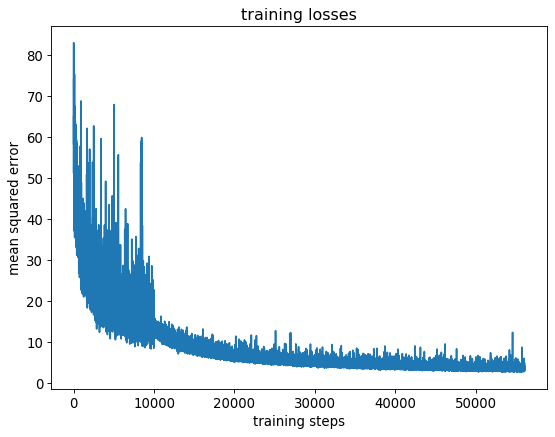

In [62]:
plt.plot(trn_losses)
# plt.plot(val_losses)
plt.title("training losses")
plt.xlabel("training steps")
plt.ylabel("mean squared error")
# plt.legend(["trn", "val"])
plt.show()

In [63]:
x_prd, y_prd = data_generator(nsamples=512, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =seed_prd,
                                device = device)
prd_dataset = CahnHillDataset(x_prd, y_prd, transform_x=transformer_x, transform_y=transformer_y)

In [64]:
err = []
for ix, item_prd in enumerate(prd_dataset):
    model.eval()
    x1 = item_prd['x'][None].to(device)
    y1 = item_prd['y'][None].to(device)
    y2 = model(x1)
    err.append(np.sqrt(mse_loss(y1.detach().cpu(), y2.detach().cpu())))

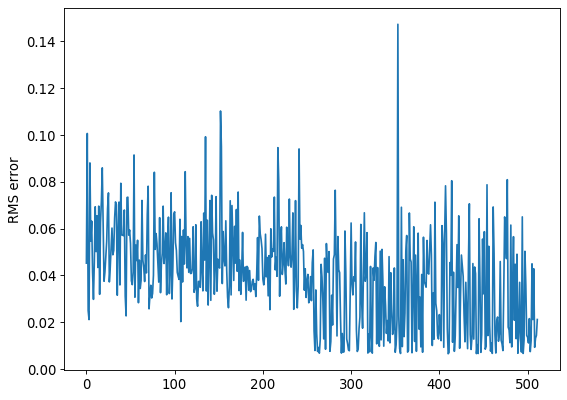

Mean Error on Validation Set: 0.0399


In [65]:

plt.plot(np.arange(len(prd_dataset)), err)
plt.ylabel("RMS error")
plt.show()

print("Mean Error on Validation Set: {:1.4f}".format(np.mean(err)))

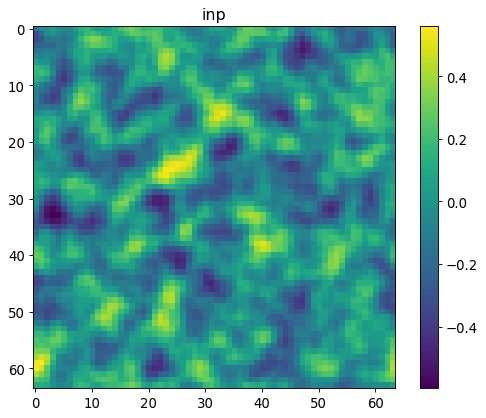

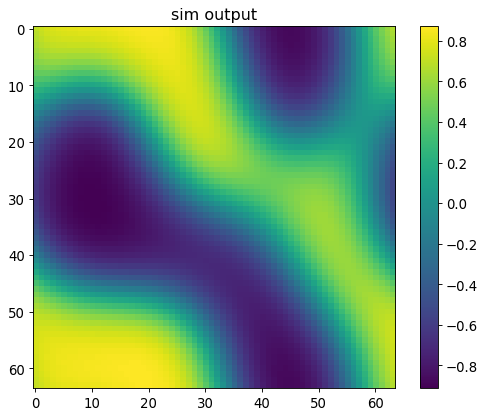

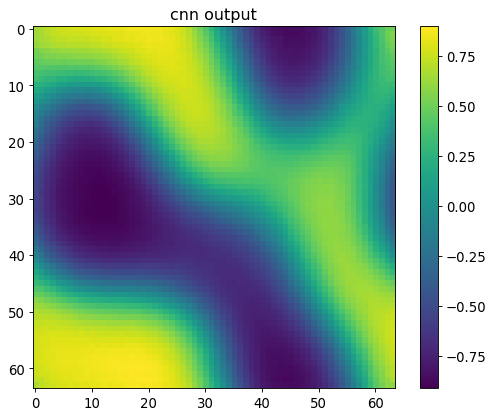

tensor(0.0047, device='cuda:0', dtype=torch.float64)


In [66]:
ix = 24

item_prd = prd_dataset[ix]
x1 = item_prd['x'][None].to(device)
y1 = item_prd['y'][None].to(device)
y2 = model(x1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1[1], "inp")
draw_im(im_y1, "sim output")
draw_im(im_y2, "cnn output")

print(mse_loss(y1, y2).data)

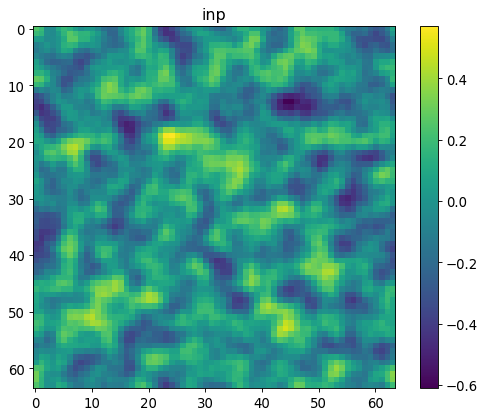

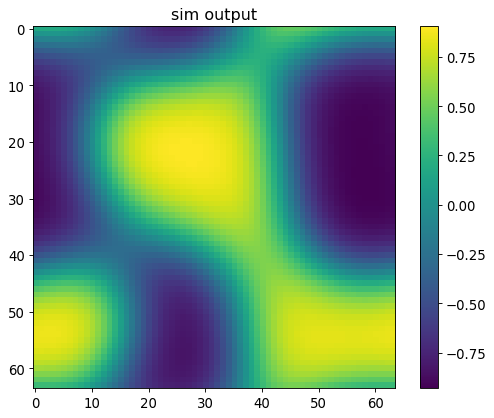

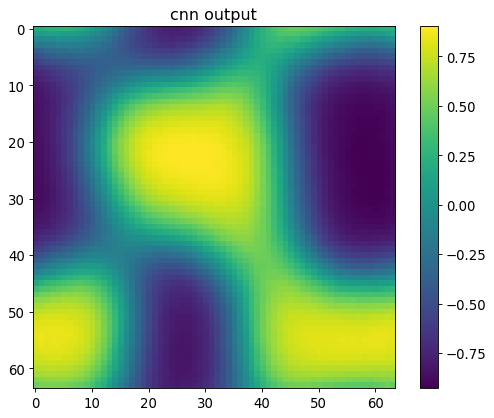

tensor(0.0043, device='cuda:0', dtype=torch.float64)


In [67]:
ix = 12

item_prd = prd_dataset[ix]
x1 = item_prd['x'][None].to(device)
y1 = item_prd['y'][None].to(device)
y2 = model(x1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1[1], "inp")
draw_im(im_y1, "sim output")
draw_im(im_y2, "cnn output")

print(mse_loss(y1, y2).data)

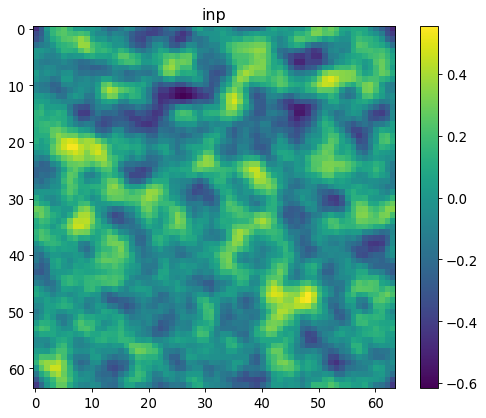

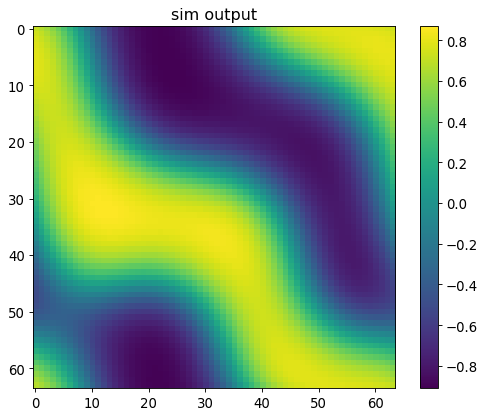

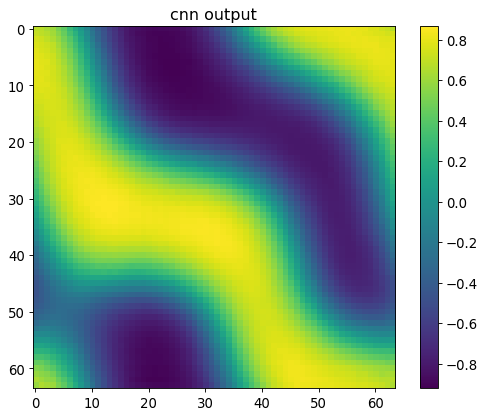

tensor(0.0015, device='cuda:0', dtype=torch.float64)


In [75]:
ix = 200

item_prd = prd_dataset[ix]
x1 = item_prd['x'][None].to(device)
y1 = item_prd['y'][None].to(device)
y2 = model(x1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1[1], "inp")
draw_im(im_y1, "sim output")
draw_im(im_y2, "cnn output")

print(mse_loss(y1, y2).data)

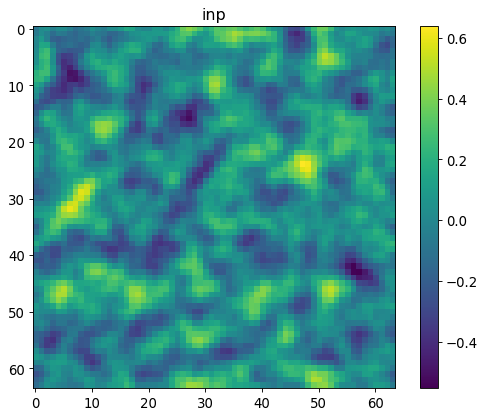

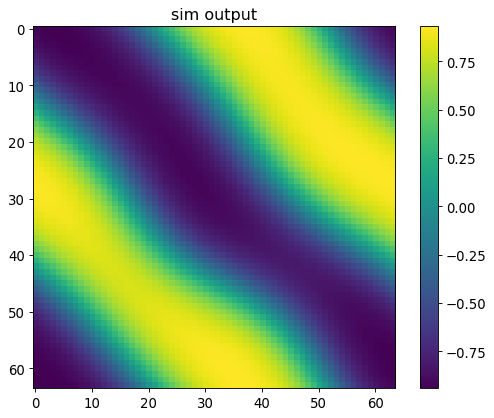

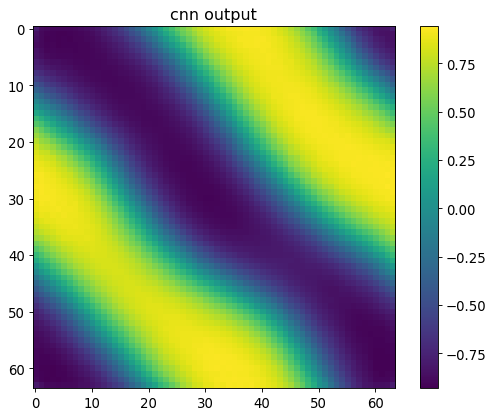

tensor(0.0004, device='cuda:0', dtype=torch.float64)


In [68]:
ix = 3

item_prd = prd_dataset[ix]
x1 = item_prd['x'][None].to(device)
y1 = item_prd['y'][None].to(device)
y2 = model(x1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1[1], "inp")
draw_im(im_y1, "sim output")
draw_im(im_y2, "cnn output")

print(mse_loss(y1, y2).data)

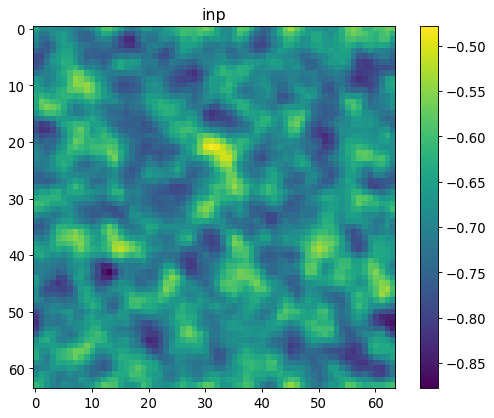

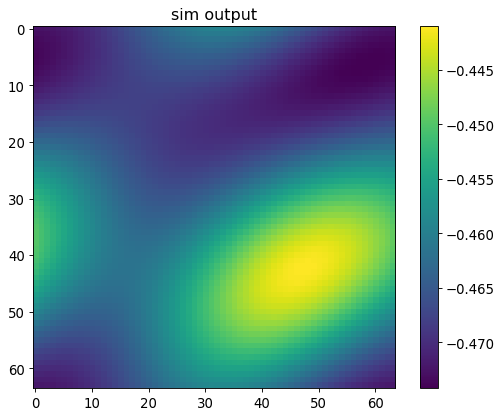

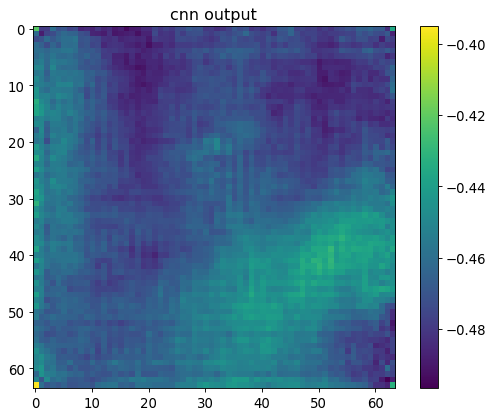

tensor(9.0032e-05, device='cuda:0', dtype=torch.float64)


In [71]:
ix = -30

item_prd = prd_dataset[ix]
x1 = item_prd['x'][None].to(device)
y1 = item_prd['y'][None].to(device)
y2 = model(x1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1[1], "inp")
draw_im(im_y1, "sim output")
draw_im(im_y2, "cnn output")

print(mse_loss(y1, y2).data)

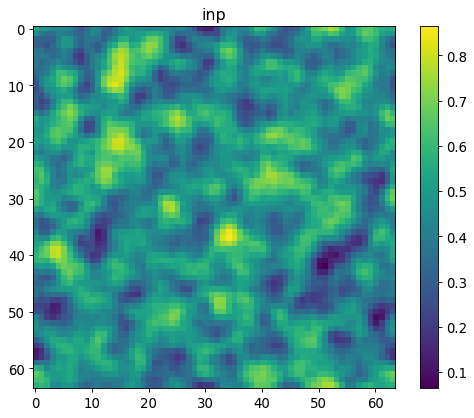

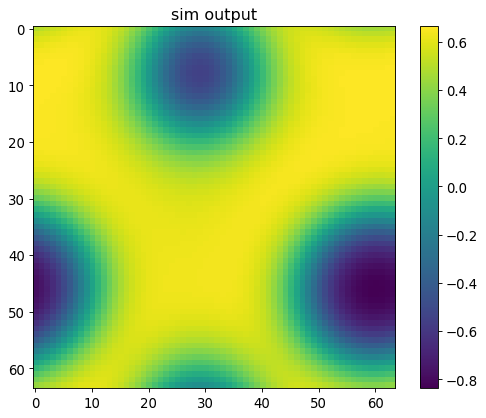

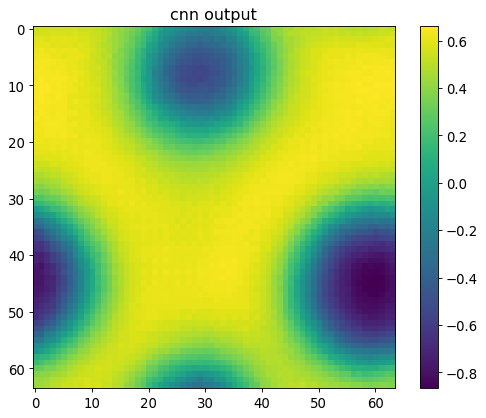

tensor(0.0021, device='cuda:0', dtype=torch.float64)


In [73]:
ix = -100

item_prd = prd_dataset[ix]
x1 = item_prd['x'][None].to(device)
y1 = item_prd['y'][None].to(device)
y2 = model(x1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1[1], "inp")
draw_im(im_y1, "sim output")
draw_im(im_y2, "cnn output")

print(mse_loss(y1, y2).data)

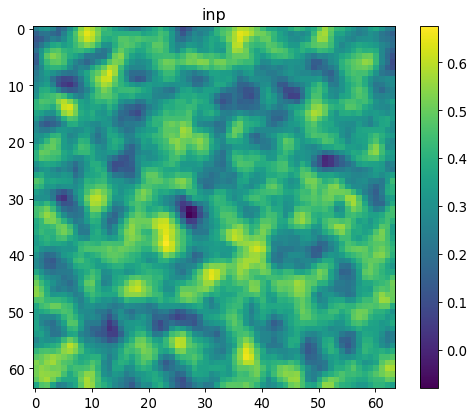

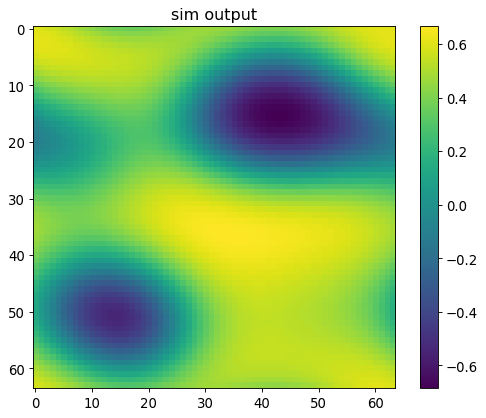

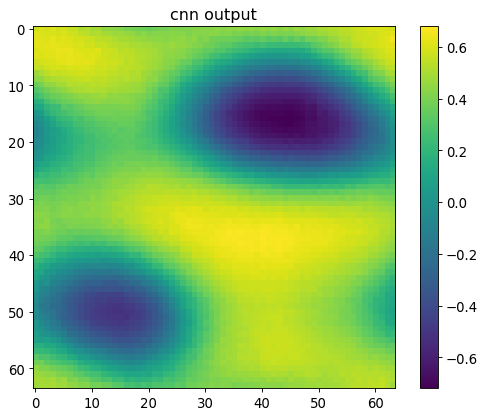

tensor(0.0024, device='cuda:0', dtype=torch.float64)


In [72]:
ix = -50

item_prd = prd_dataset[ix]
x1 = item_prd['x'][None].to(device)
y1 = item_prd['y'][None].to(device)
y2 = model(x1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1[1], "inp")
draw_im(im_y1, "sim output")
draw_im(im_y2, "cnn output")

print(mse_loss(y1, y2).data)

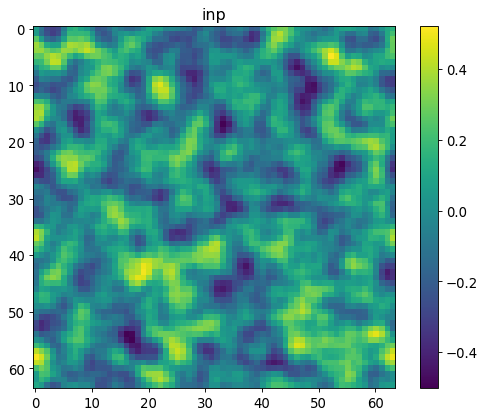

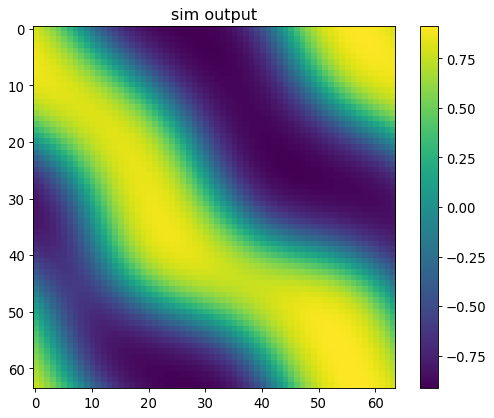

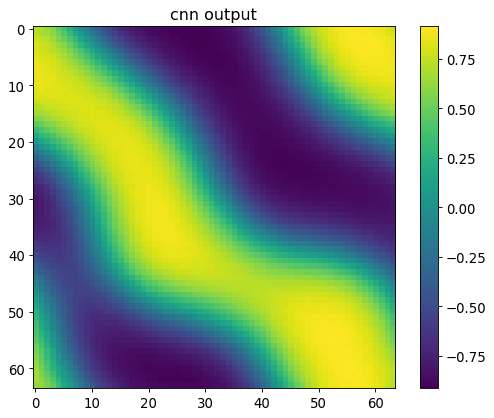

tensor(0.0010, device='cuda:0', dtype=torch.float64)


In [69]:
ix = 15

item_prd = prd_dataset[ix]
x1 = item_prd['x'][None].to(device)
y1 = item_prd['y'][None].to(device)
y2 = model(x1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1[1], "inp")
draw_im(im_y1, "sim output")
draw_im(im_y2, "cnn output")

print(mse_loss(y1, y2).data)